In [ ]:
from types import SimpleNamespace

In [ ]:
pip install fastprogress

In [ ]:
import sys
sys.path.append('/home/user/.local/lib/python3.8/site-packages')
from fastprogress import progress_bar


In [ ]:
pip install wandb

In [ ]:
pip install fastdownload

## Helper functions

In [ ]:
from helpers import one_batch, plot_images, save_images

## Architecture of the model

### EMA (Exponential Moving Average) model

In [ ]:
from ema import EMA, one_param

### Creating Unet_conditional model

In [ ]:
from Unet import SelfAttention, DoubleConv, Down, Up, UNet, UNet_conditional

### Setting training class

In [ ]:
import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext

import torch
from torch import optim
import torch.nn as nn
import numpy as np
from fastprogress import progress_bar

import wandb

import os
import urllib.request
import tarfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bar


from diffusion import Diffusion


config = SimpleNamespace(
    run_name = "DDPM_conditional",
    epochs = 100,
    noise_steps=1000,
    seed = 42,
    batch_size = 10,
    img_size = 64,
    num_classes = 10,
    train_folder = "train",
    val_folder = "test",
    device = "cuda",
    slice_size = 1,
    do_validation = True,
    fp16 = True,
    log_every_epoch = 10,
    num_workers=10,
    lr = 5e-3)


logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")





def parse_args(config):
    parser = argparse.ArgumentParser(description='Process hyper-parameters')
    parser.add_argument('--run_name', type=str, default=config.run_name, help='name of the run')
    parser.add_argument('--epochs', type=int, default=config.epochs, help='number of epochs')
    parser.add_argument('--seed', type=int, default=config.seed, help='random seed')
    parser.add_argument('--batch_size', type=int, default=config.batch_size, help='batch size')
    parser.add_argument('--img_size', type=int, default=config.img_size, help='image size')
    parser.add_argument('--num_classes', type=int, default=config.num_classes, help='number of classes')
    parser.add_argument('--device', type=str, default=config.device, help='device')
    parser.add_argument('--lr', type=float, default=config.lr, help='learning rate')
    parser.add_argument('--slice_size', type=int, default=config.slice_size, help='slice size')
    parser.add_argument('--noise_steps', type=int, default=config.noise_steps, help='noise steps')
    args = vars(parser.parse_args())

    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)


if __name__ == '__main__':
    parse_args(config)

    ## seed everything
    diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
    with wandb.init(project="train_sd", group="train", config=config):
        diffuser.prepare(config)
        diffuser.fit(config)


usage: ipykernel_launcher.py [-h] [--run_name RUN_NAME] [--epochs EPOCHS]
                             [--seed SEED] [--batch_size BATCH_SIZE]
                             [--img_size IMG_SIZE] [--num_classes NUM_CLASSES]
                             [--device DEVICE] [--lr LR]
                             [--slice_size SLICE_SIZE]
                             [--noise_steps NOISE_STEPS]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/user/.local/share/jupyter/runtime/kernel-975c8e42-7c75-444c-9456-a4c2b293e82d.json


SystemExit: 2

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Setting parameters for training model

In [ ]:
import argparse
from pathlib import Path

class Config:
    def __init__(self):
        # Set default values for each attribute
        self.run_name = 'DDPM_conditional'
        self.epochs = 100
        self.noise_steps = 1000
        self.seed = 42
        self.batch_size = 128
        self.img_size = 64
        self.num_classes = 10

        self.device = 'cuda'
        self.slice_size = 1
        self.use_wandb = True
        self.do_validation = False
        self.log_every_epoch = 10
        self.num_workers = 10
        self.lr = 0.0003

    def parse_args(self):
        parser = argparse.ArgumentParser(description='Process hyper-parameters')

        parser.add_argument('--run_name', type=str, default=self.run_name, help='name of the run')
        parser.add_argument('--epochs', type=int, default=self.epochs, help='number of epochs')
        parser.add_argument('--noise_steps', type=int, default=self.noise_steps, help='noise steps')
        parser.add_argument('--seed', type=int, default=self.seed, help='random seed')
        parser.add_argument('--batch_size', type=int, default=self.batch_size, help='batch size')
        parser.add_argument('--img_size', type=int, default=self.img_size, help='image size')
        parser.add_argument('--num_classes', type=int, default=self.num_classes, help='number of classes')

        parser.add_argument('--device', type=str, default=self.device, help='device')
        parser.add_argument('--slice_size', type=int, default=self.slice_size, help='slice size')
        parser.add_argument('--use_wandb', type=bool, default=self.use_wandb, help='use Weights & Biases')
        parser.add_argument('--do_validation', type=bool, default=self.do_validation, help='perform validation')
        parser.add_argument('--log_every_epoch', type=int, default=self.log_every_epoch, help='logging interval')
        parser.add_argument('--num_workers', type=int, default=self.num_workers, help='number of workers')
        parser.add_argument('--lr', type=float, default=self.lr, help='learning rate')

        args, _ = parser.parse_known_args()

        for key, value in vars(args).items():
            setattr(self, key, value)

    def __repr__(self):
        return f"Config({', '.join([f'{k}={v}' for k, v in self.__dict__.items()])})"

# Example usage
config = Config()
config.parse_args()
print(config)


Config(run_name=DDPM_conditional, epochs=100, noise_steps=1000, seed=42, batch_size=128, img_size=64, num_classes=10, device=cuda, slice_size=1, use_wandb=True, do_validation=False, log_every_epoch=10, num_workers=10, lr=0.0003)


## Performing training:

09:42:08 - ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: abdurahmon_a (abdurahmon_a-innopolis-university). Use `wandb login --relogin` to force relogin


09:42:10 - INFO: Starting epoch 0:


/tmp/ipykernel_4502/130008081.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
09:43:40 - INFO: Sampling 10 new images....


09:45:02 - INFO: Sampling 10 new images....


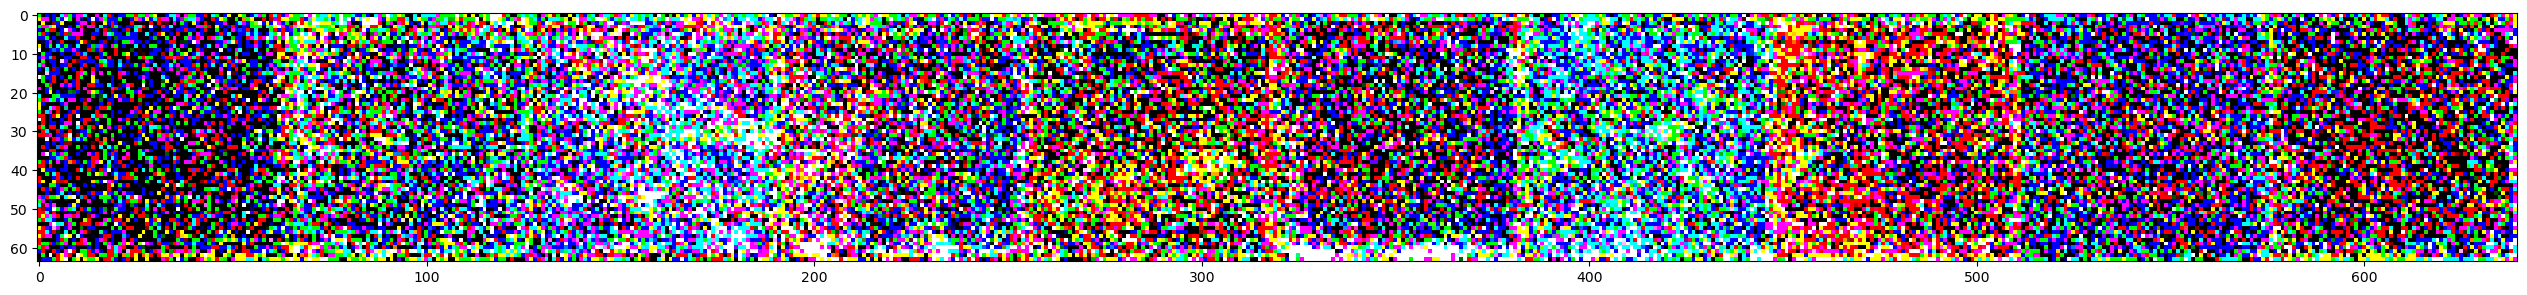

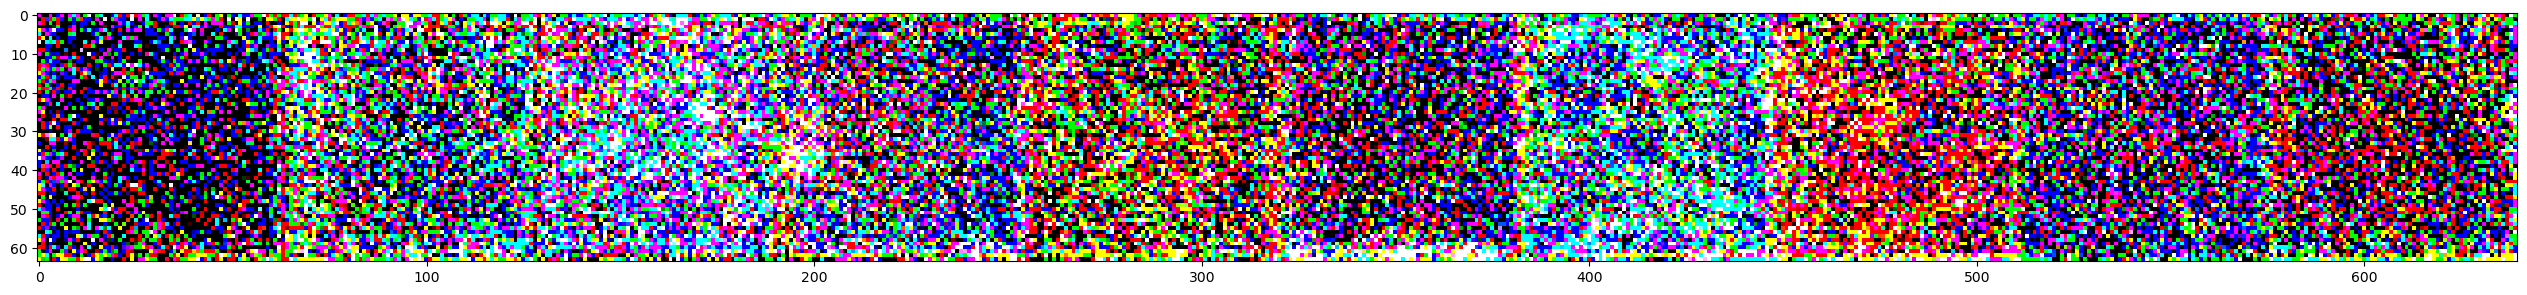

09:46:25 - INFO: Starting epoch 1:


09:47:57 - INFO: Starting epoch 2:


09:49:31 - INFO: Starting epoch 3:


09:51:04 - INFO: Starting epoch 4:


09:52:35 - INFO: Starting epoch 5:


09:54:06 - INFO: Starting epoch 6:


09:55:39 - INFO: Starting epoch 7:


09:57:11 - INFO: Starting epoch 8:


09:58:43 - INFO: Starting epoch 9:


10:00:21 - INFO: Starting epoch 10:


10:01:56 - INFO: Sampling 10 new images....


10:03:19 - INFO: Sampling 10 new images....


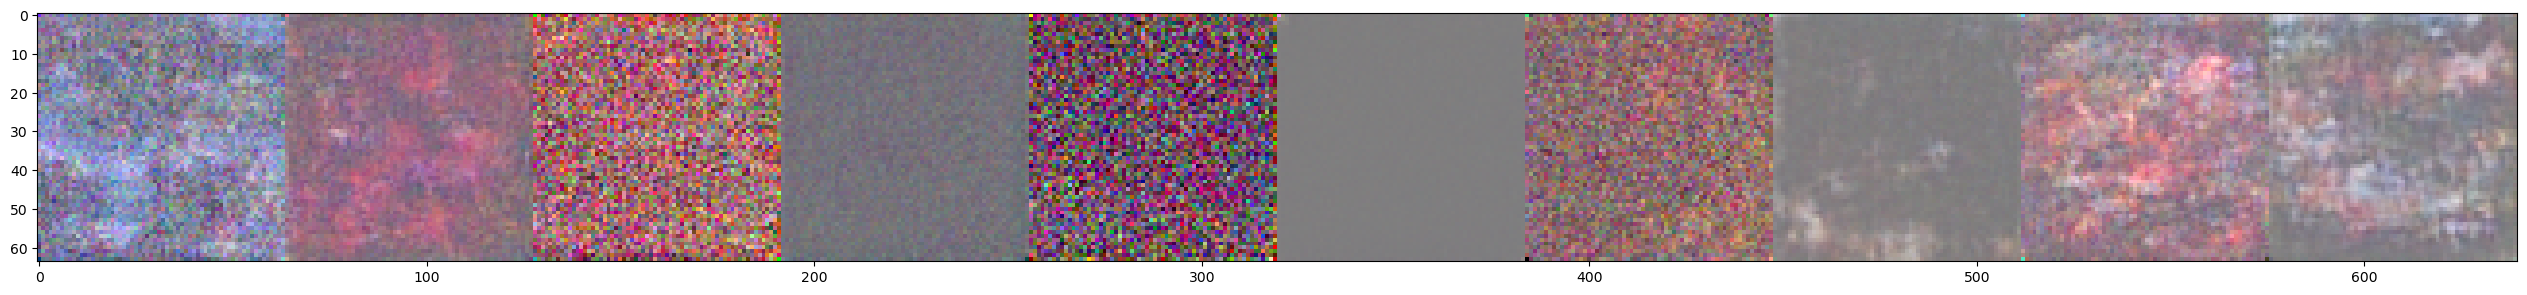

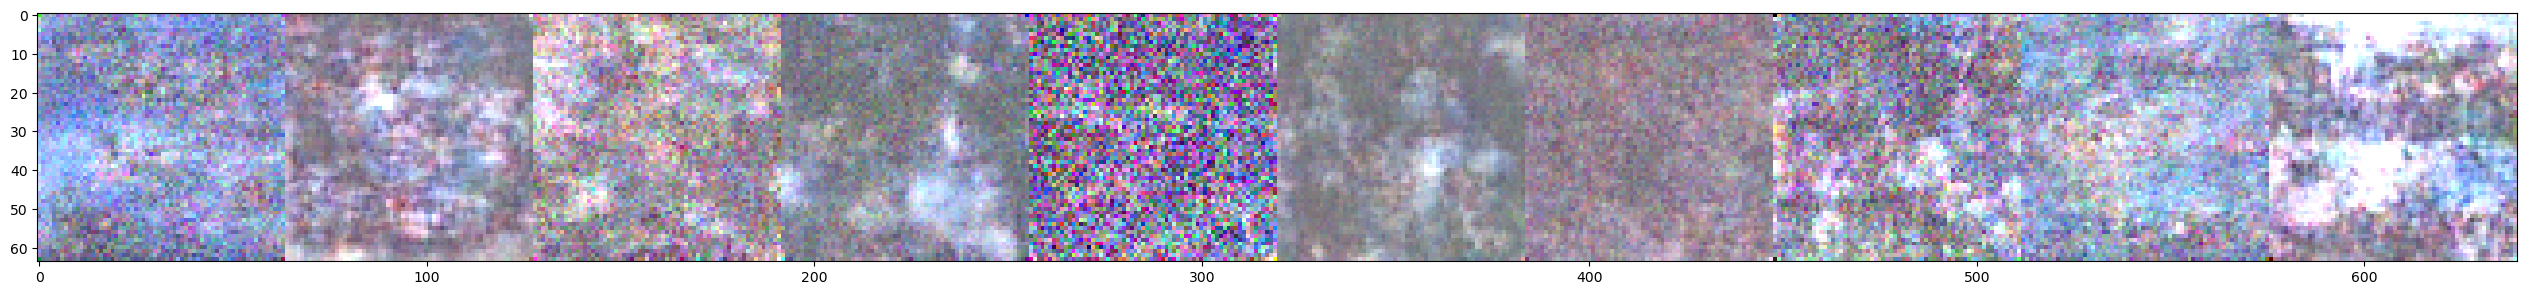

10:04:46 - INFO: Starting epoch 11:


10:06:18 - INFO: Starting epoch 12:


10:07:51 - INFO: Starting epoch 13:


10:09:23 - INFO: Starting epoch 14:


10:10:56 - INFO: Starting epoch 15:


10:12:28 - INFO: Starting epoch 16:


10:14:01 - INFO: Starting epoch 17:


10:15:34 - INFO: Starting epoch 18:


10:17:06 - INFO: Starting epoch 19:


10:18:39 - INFO: Starting epoch 20:


10:20:11 - INFO: Sampling 10 new images....


10:21:32 - INFO: Sampling 10 new images....


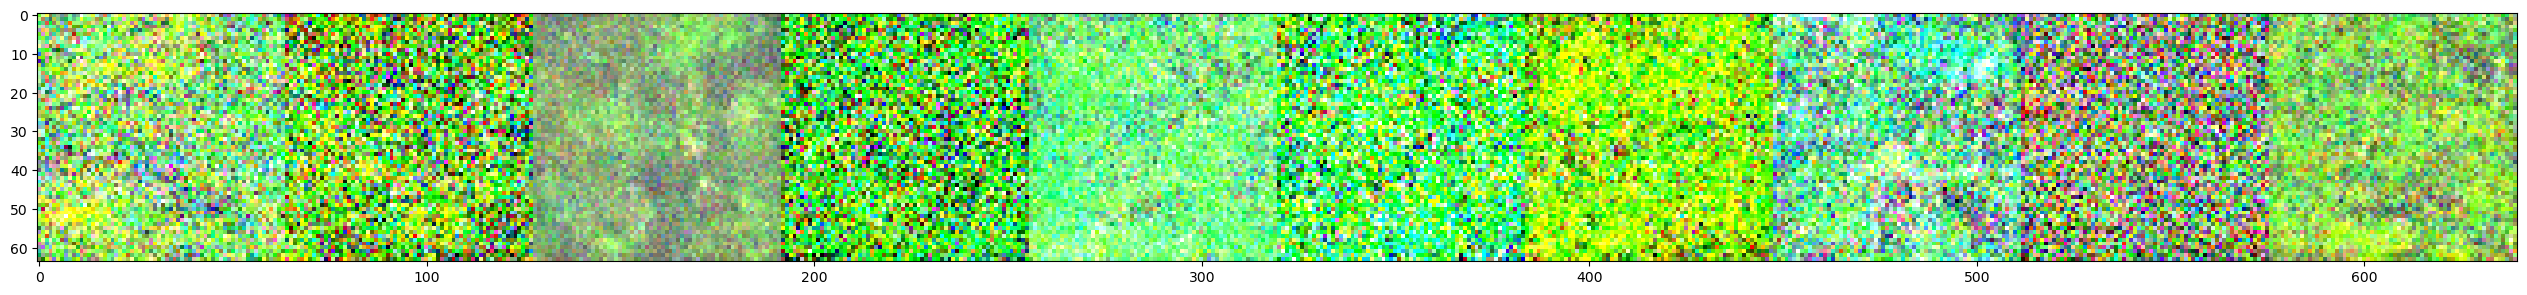

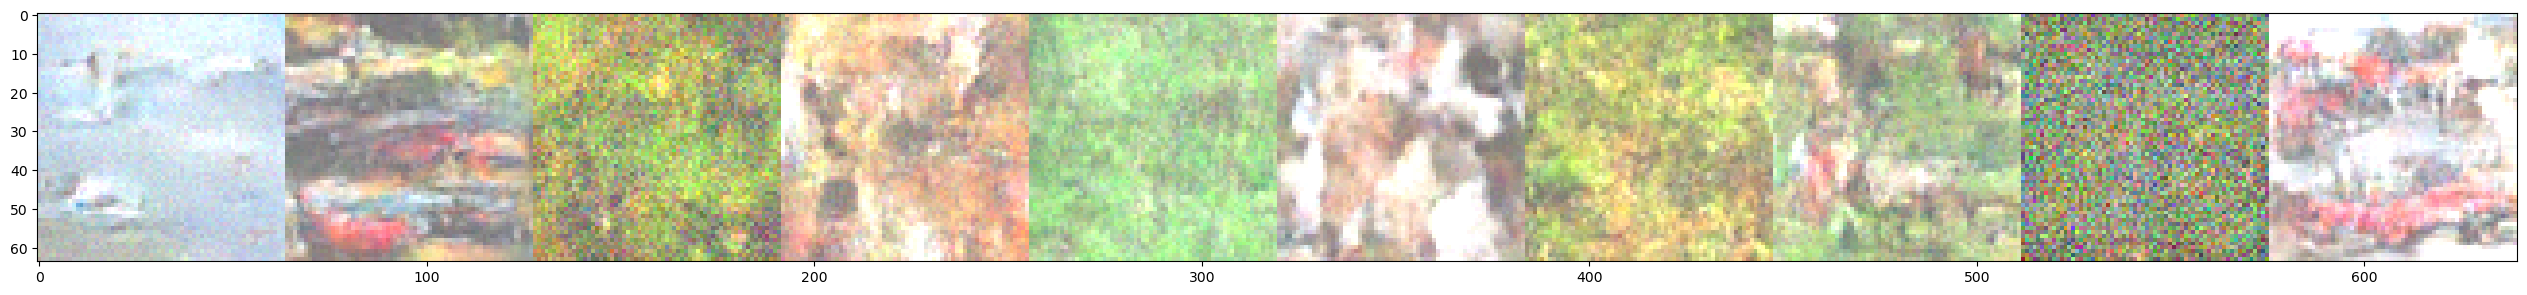

10:22:55 - INFO: Starting epoch 21:


10:24:28 - INFO: Starting epoch 22:


10:26:00 - INFO: Starting epoch 23:


10:27:33 - INFO: Starting epoch 24:


10:30:39 - INFO: Starting epoch 26:


10:32:13 - INFO: Starting epoch 27:


10:33:51 - INFO: Starting epoch 28:


10:35:23 - INFO: Starting epoch 29:


10:36:54 - INFO: Starting epoch 30:


10:38:24 - INFO: Sampling 10 new images....


10:39:45 - INFO: Sampling 10 new images....


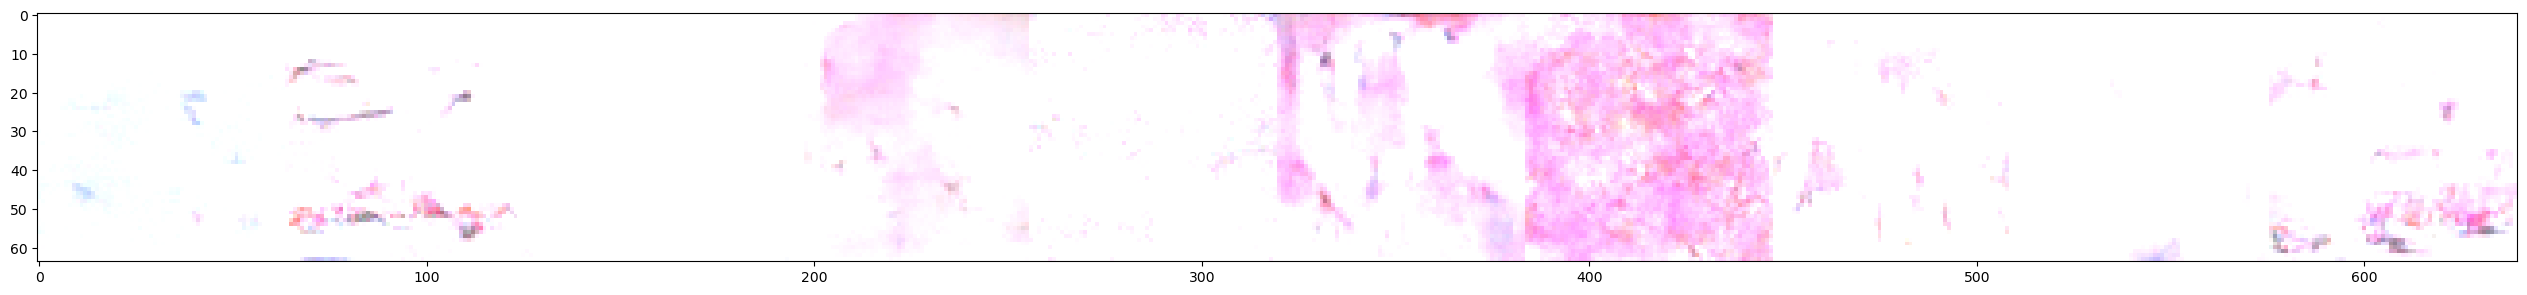

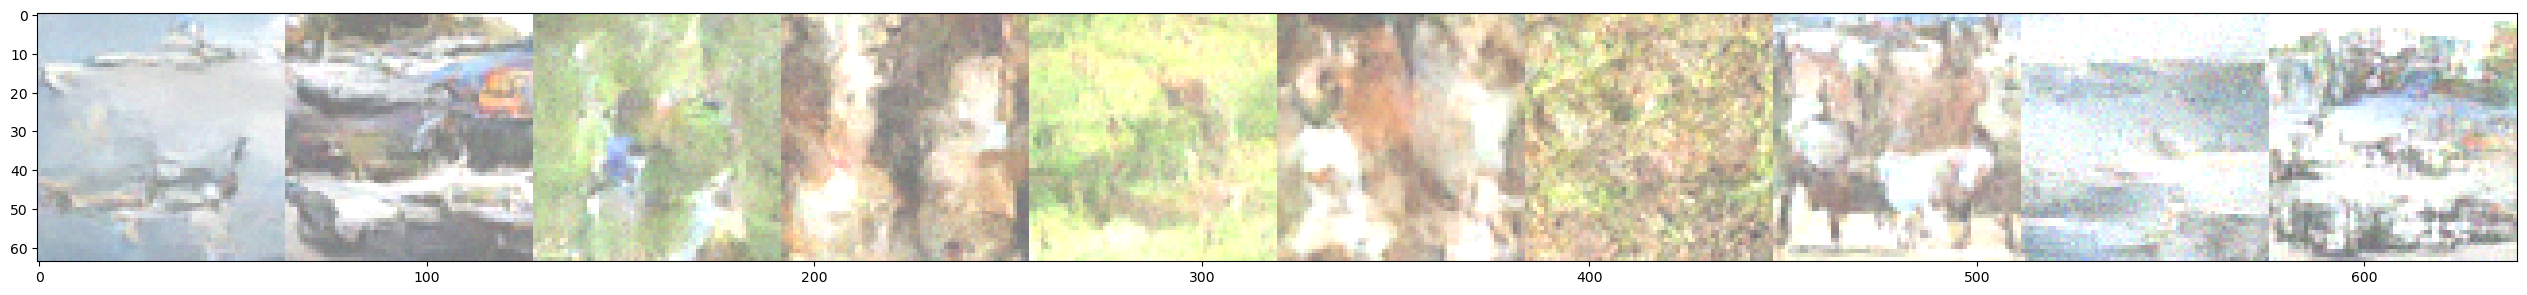

10:41:07 - INFO: Starting epoch 31:


10:42:38 - INFO: Starting epoch 32:


10:44:07 - INFO: Starting epoch 33:


10:45:39 - INFO: Starting epoch 34:


10:47:13 - INFO: Starting epoch 35:


10:48:44 - INFO: Starting epoch 36:


10:50:13 - INFO: Starting epoch 37:


10:51:45 - INFO: Starting epoch 38:


10:53:17 - INFO: Starting epoch 39:


10:54:49 - INFO: Starting epoch 40:


10:56:24 - INFO: Sampling 10 new images....


10:57:45 - INFO: Sampling 10 new images....


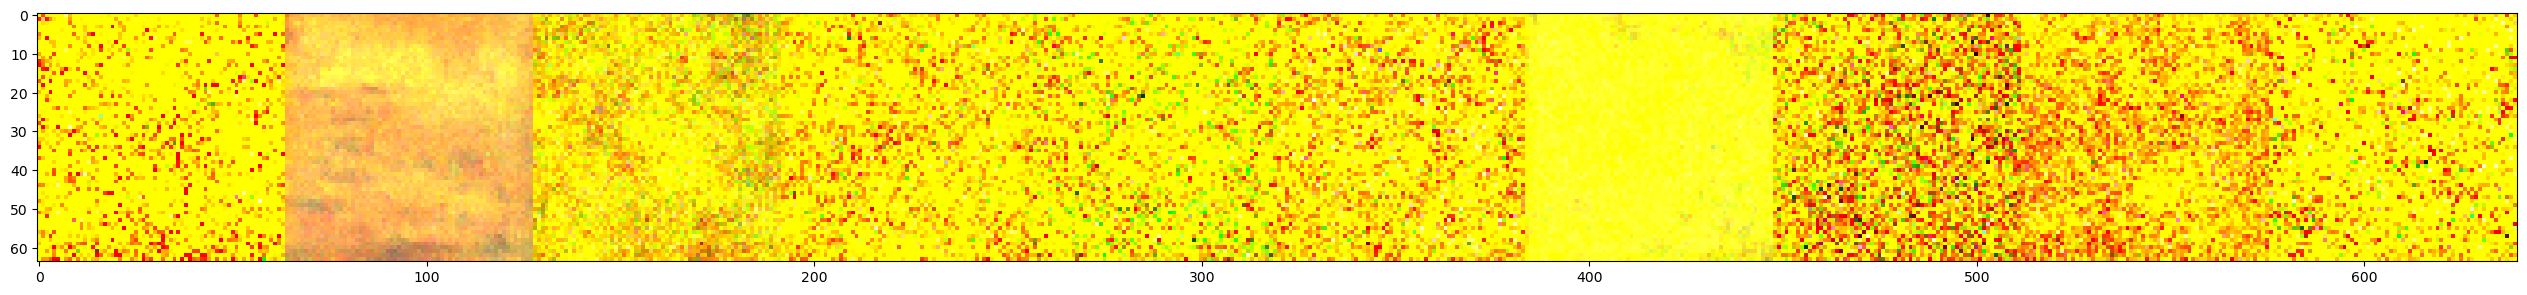

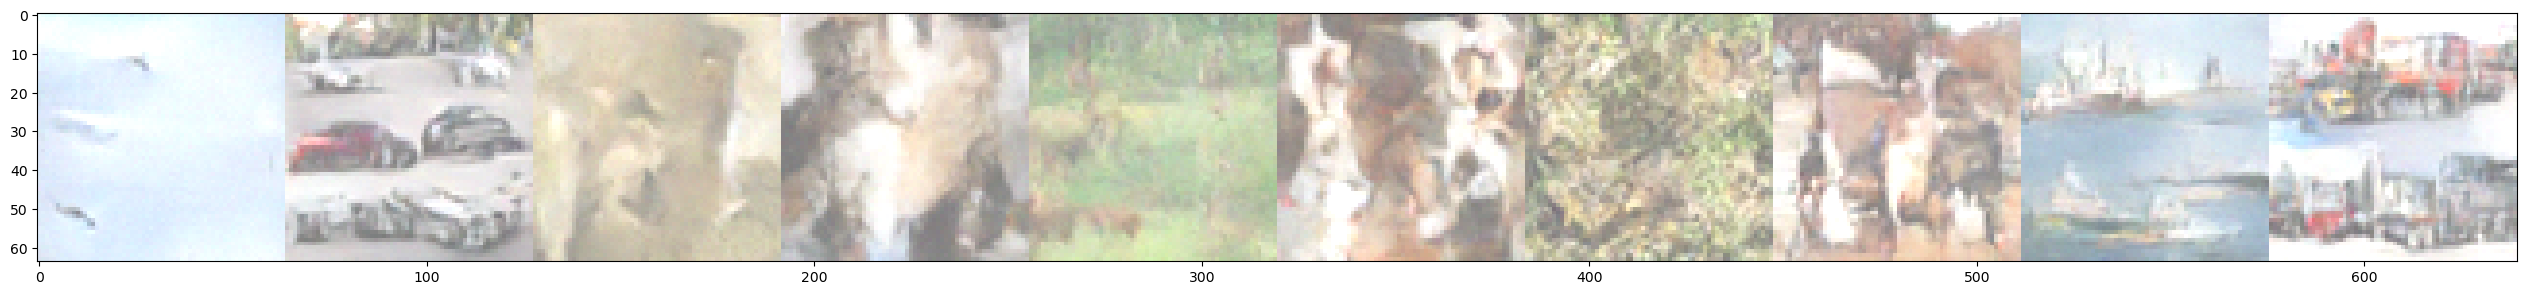

10:59:07 - INFO: Starting epoch 41:


11:00:38 - INFO: Starting epoch 42:


11:02:09 - INFO: Starting epoch 43:


11:03:36 - INFO: Starting epoch 44:


11:05:03 - INFO: Starting epoch 45:


11:06:30 - INFO: Starting epoch 46:


11:07:57 - INFO: Starting epoch 47:


11:09:24 - INFO: Starting epoch 48:


11:10:51 - INFO: Starting epoch 49:


11:12:18 - INFO: Starting epoch 50:


11:13:46 - INFO: Sampling 10 new images....


11:15:06 - INFO: Sampling 10 new images....


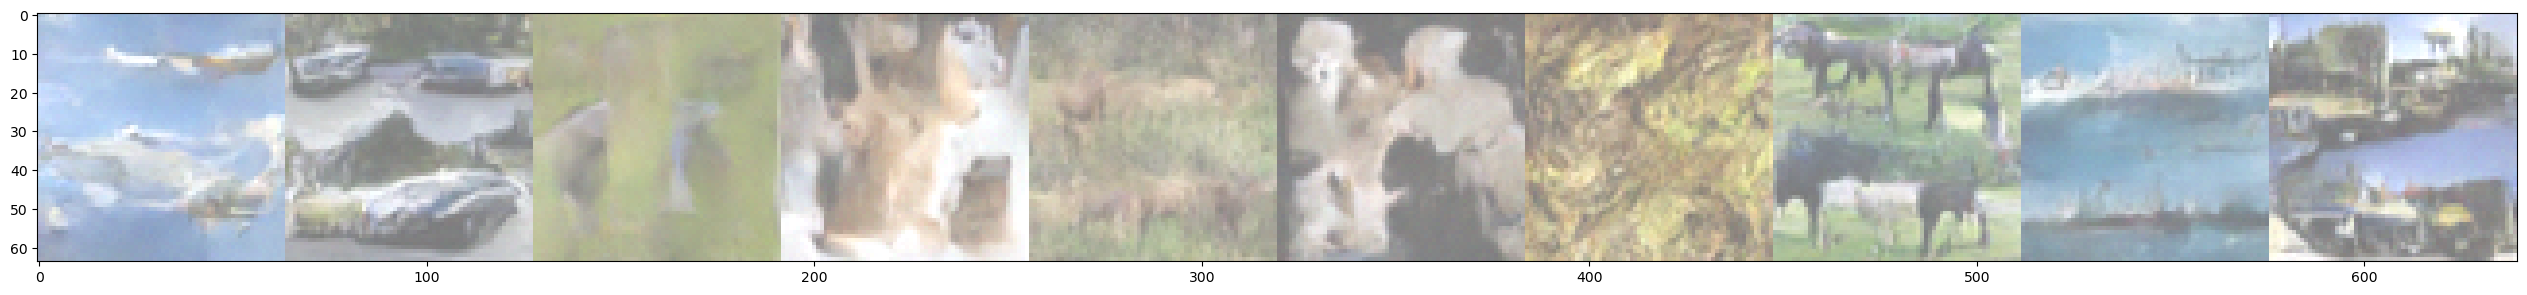

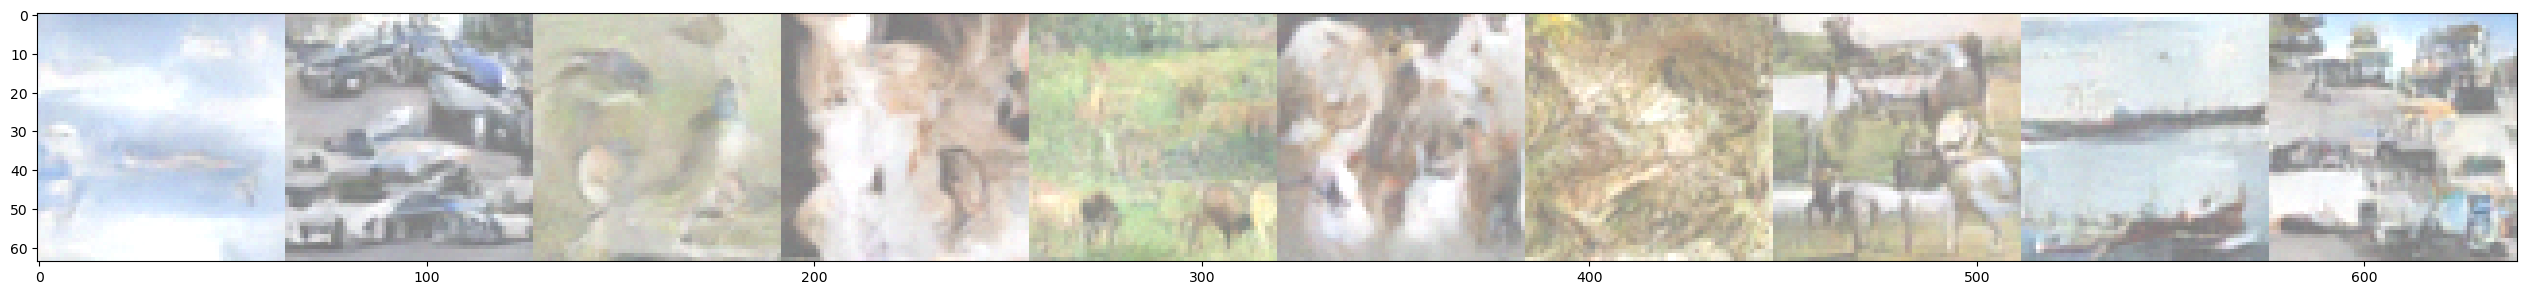

11:16:28 - INFO: Starting epoch 51:


11:17:55 - INFO: Starting epoch 52:


11:19:23 - INFO: Starting epoch 53:


11:20:50 - INFO: Starting epoch 54:


11:22:17 - INFO: Starting epoch 55:


11:23:45 - INFO: Starting epoch 56:


11:25:12 - INFO: Starting epoch 57:


11:26:40 - INFO: Starting epoch 58:


11:28:07 - INFO: Starting epoch 59:


11:29:35 - INFO: Starting epoch 60:


11:31:03 - INFO: Sampling 10 new images....


11:32:23 - INFO: Sampling 10 new images....


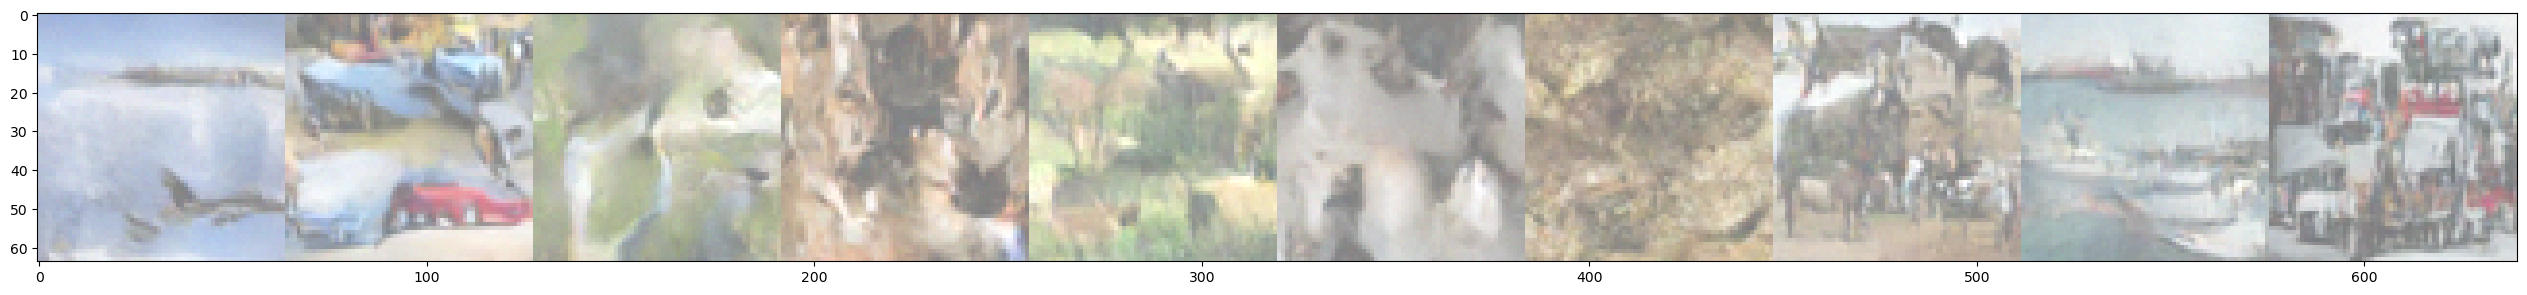

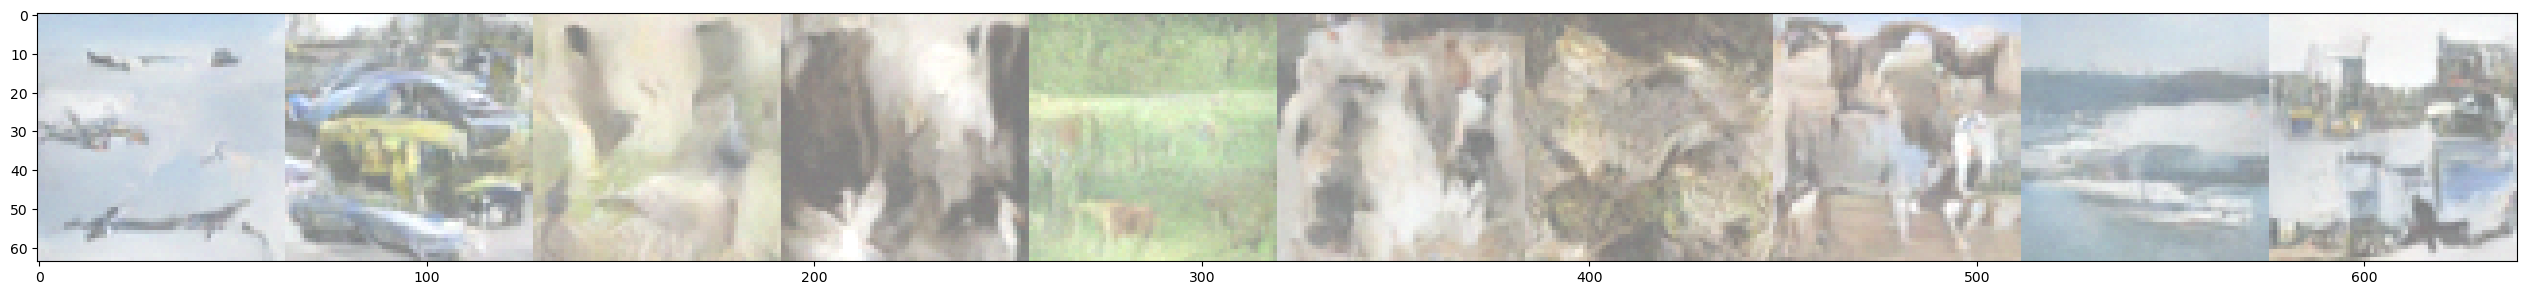

11:33:45 - INFO: Starting epoch 61:


11:35:12 - INFO: Starting epoch 62:


11:36:40 - INFO: Starting epoch 63:


11:38:08 - INFO: Starting epoch 64:


11:39:35 - INFO: Starting epoch 65:


11:41:02 - INFO: Starting epoch 66:


11:42:30 - INFO: Starting epoch 67:


11:43:57 - INFO: Starting epoch 68:


11:45:25 - INFO: Starting epoch 69:


11:46:52 - INFO: Starting epoch 70:


11:48:19 - INFO: Sampling 10 new images....


11:49:40 - INFO: Sampling 10 new images....


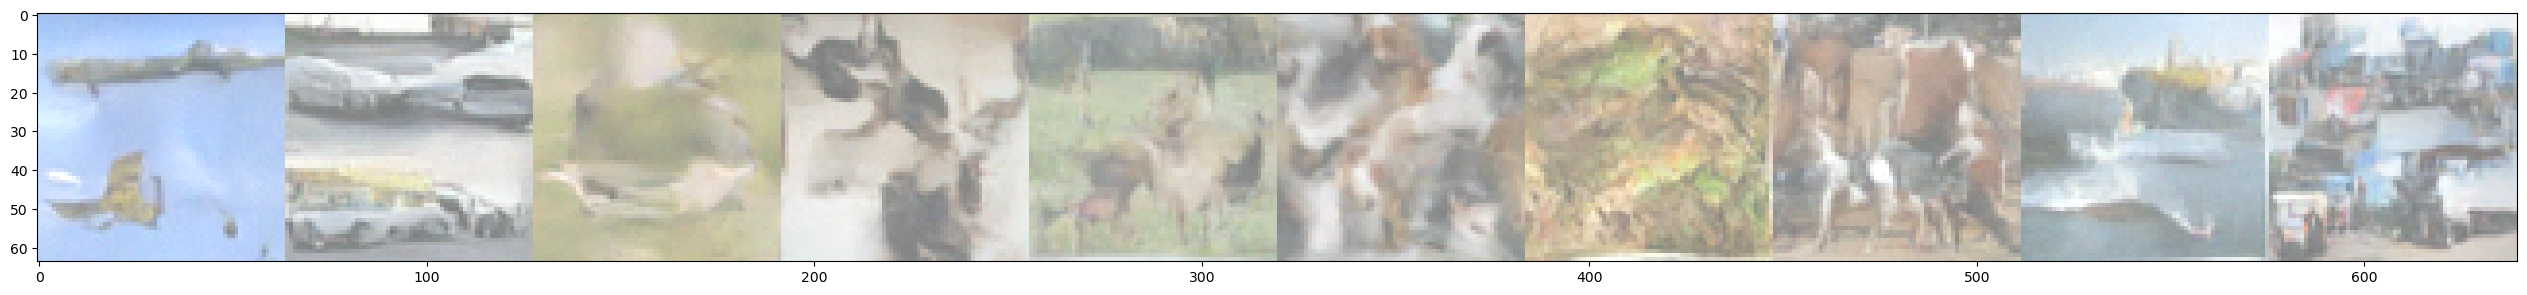

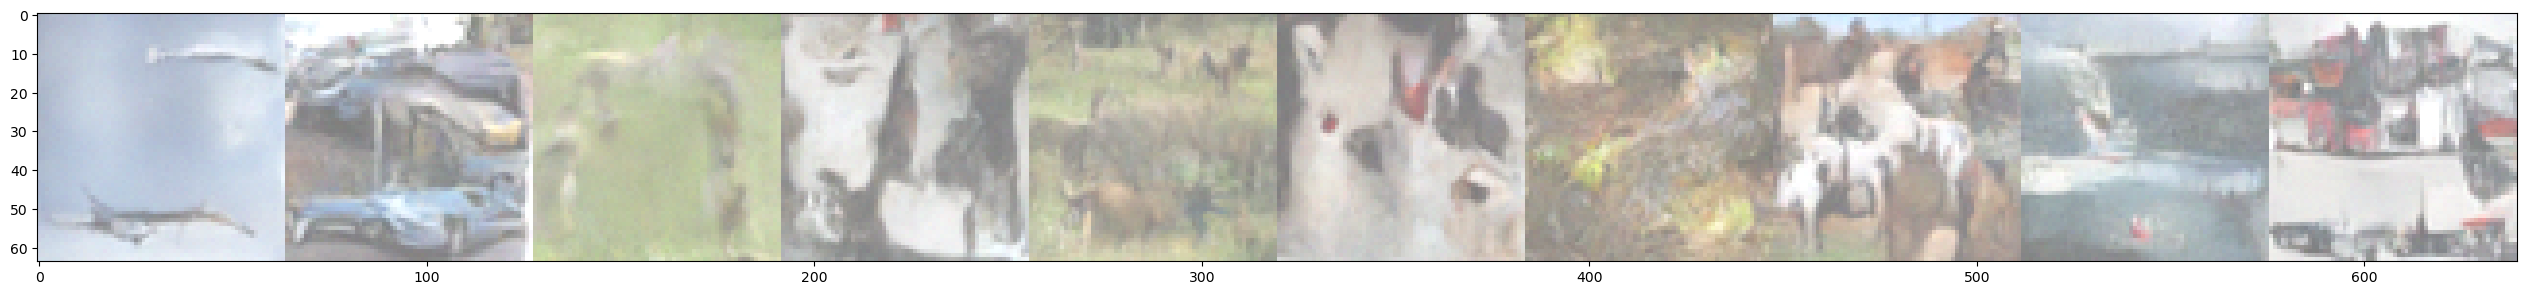

11:51:02 - INFO: Starting epoch 71:


11:52:30 - INFO: Starting epoch 72:


11:53:57 - INFO: Starting epoch 73:


11:55:25 - INFO: Starting epoch 74:


11:56:53 - INFO: Starting epoch 75:


11:58:20 - INFO: Starting epoch 76:


11:59:48 - INFO: Starting epoch 77:


12:01:15 - INFO: Starting epoch 78:


12:02:43 - INFO: Starting epoch 79:


12:04:10 - INFO: Starting epoch 80:


12:05:39 - INFO: Sampling 10 new images....


12:06:59 - INFO: Sampling 10 new images....


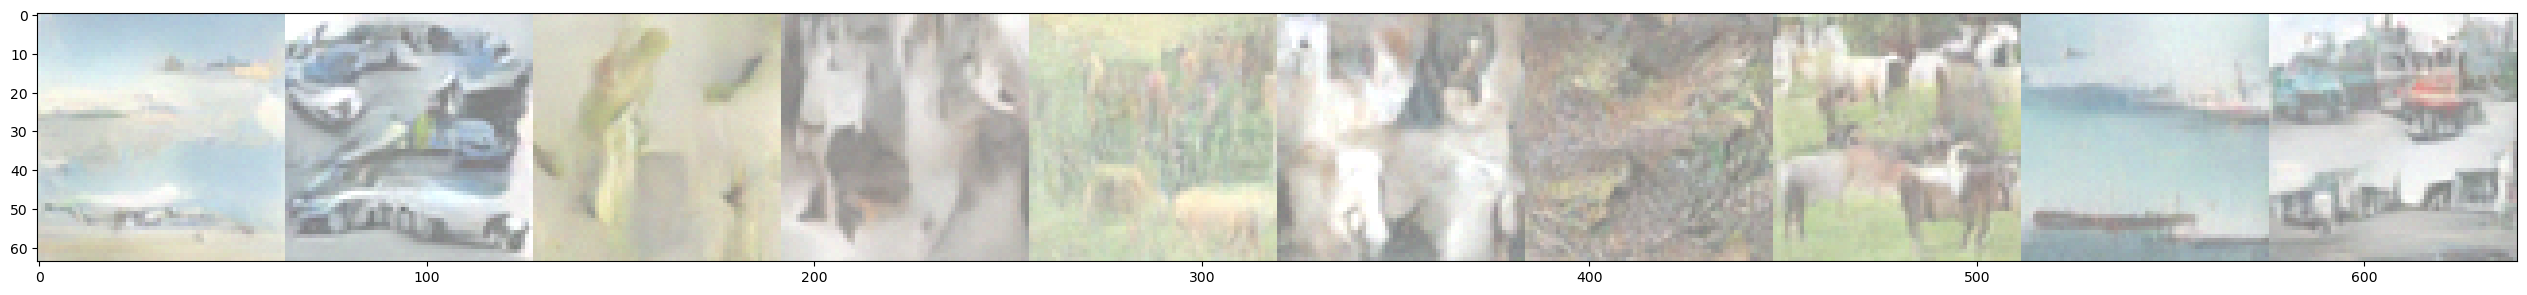

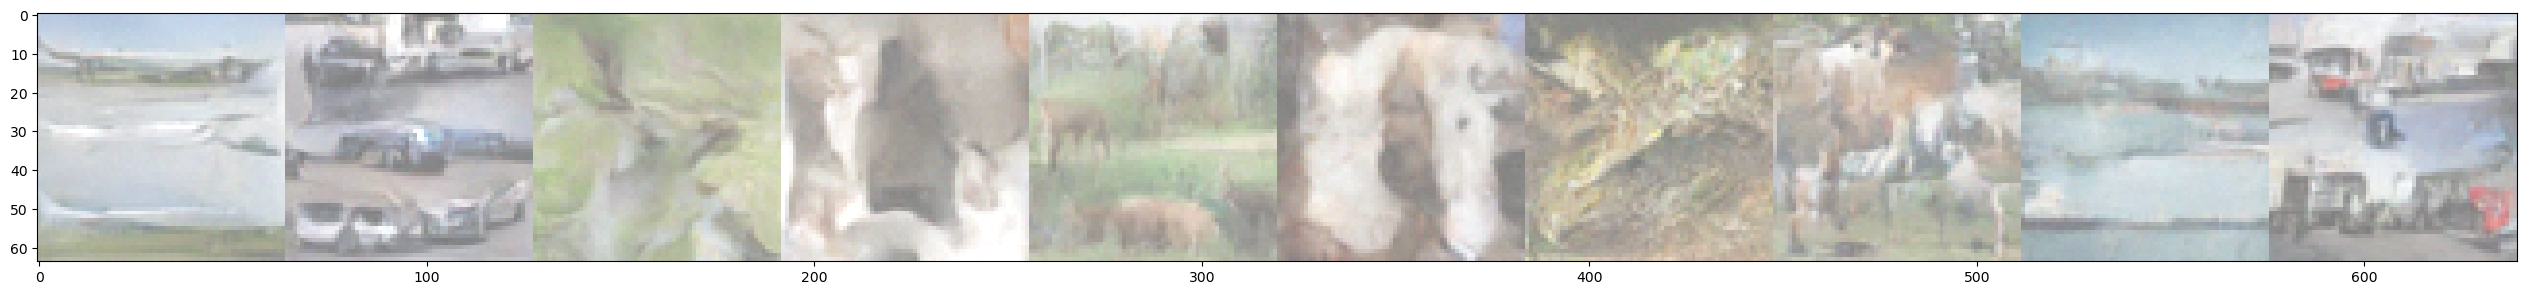

12:08:21 - INFO: Starting epoch 81:


12:09:49 - INFO: Starting epoch 82:


12:11:16 - INFO: Starting epoch 83:


12:12:43 - INFO: Starting epoch 84:


12:14:10 - INFO: Starting epoch 85:


12:15:37 - INFO: Starting epoch 86:


12:17:04 - INFO: Starting epoch 87:


12:18:31 - INFO: Starting epoch 88:


12:19:58 - INFO: Starting epoch 89:


12:21:25 - INFO: Starting epoch 90:


12:22:51 - INFO: Sampling 10 new images....


12:24:12 - INFO: Sampling 10 new images....


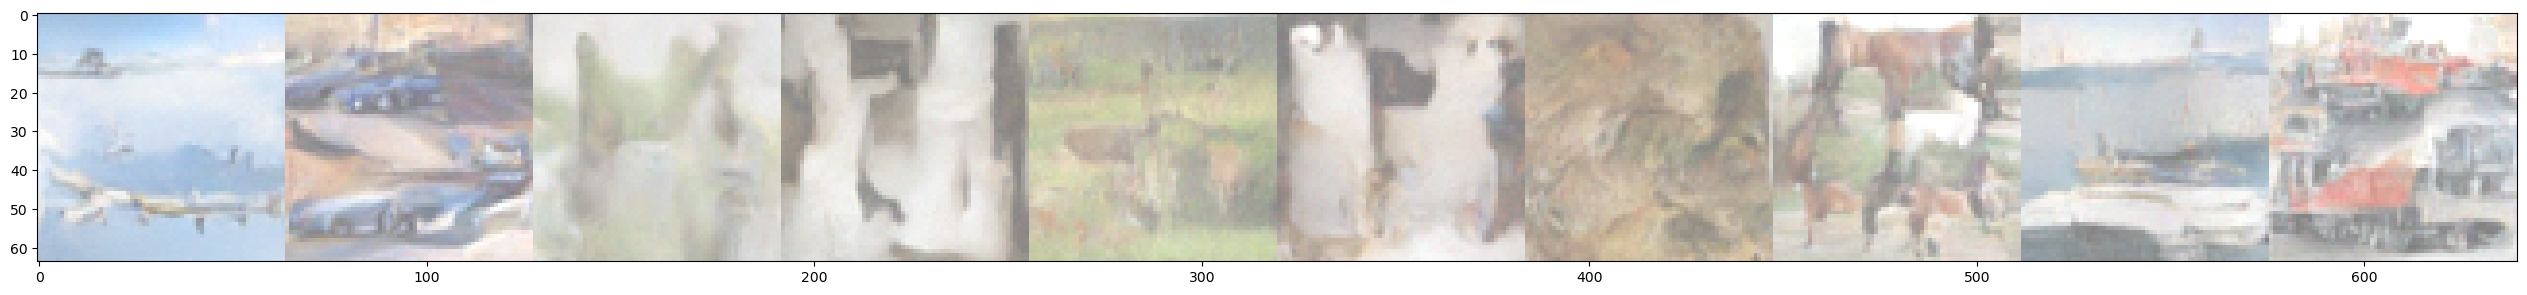

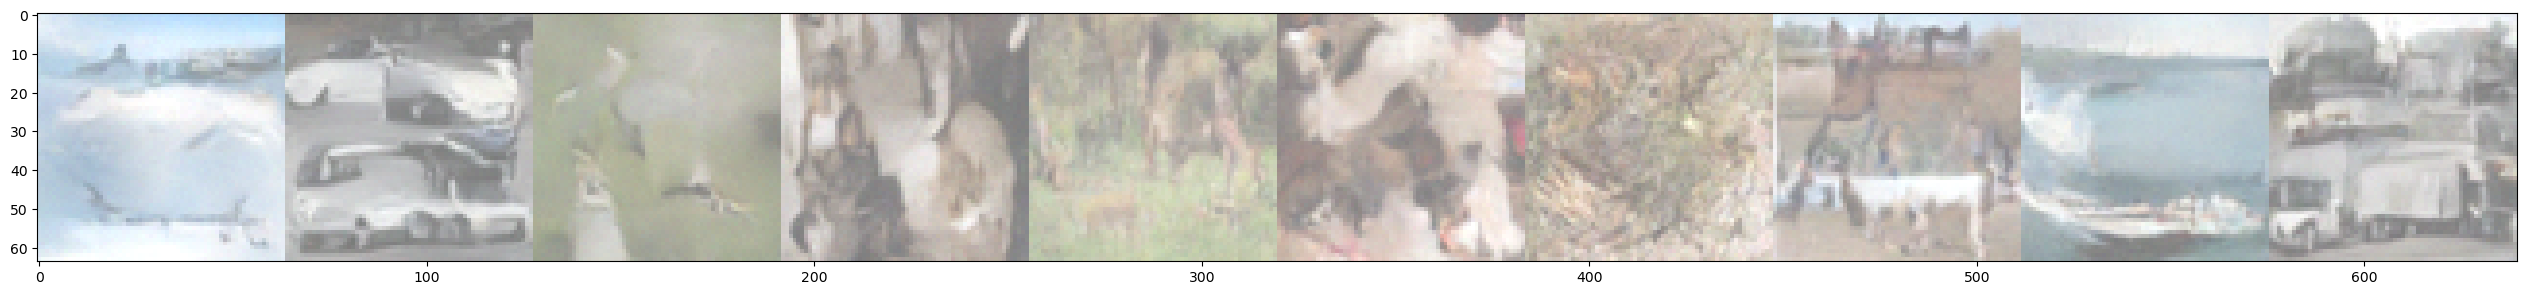

12:25:34 - INFO: Starting epoch 91:


12:27:01 - INFO: Starting epoch 92:


12:28:28 - INFO: Starting epoch 93:


12:29:55 - INFO: Starting epoch 94:


12:31:22 - INFO: Starting epoch 95:


12:32:49 - INFO: Starting epoch 96:


12:34:17 - INFO: Starting epoch 97:


12:35:44 - INFO: Starting epoch 98:


12:37:11 - INFO: Starting epoch 99:


Traceback (most recent call last):
  File "/tmp/ipykernel_4502/3945518532.py", line 4, in <module>
    diffuser.fit(config)
  File "/tmp/ipykernel_4502/130008081.py", line 216, in fit
    self.save_model(run_name=args.run_name, epoch=epoch)
  File "/tmp/ipykernel_4502/130008081.py", line 154, in save_model
    torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: Parent directory models/DDPM_conditional does not exist.


RuntimeError: Parent directory models/DDPM_conditional does not exist.

In [ ]:
diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
with wandb.init(project="train_sd", group="train", config=config):
    diffuser.prepare(config)
    diffuser.fit(config)


In [ ]:
import os

# Path to the desired directory
directory_path = "models/DDPM_conditional"

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

print(f"Directory '{directory_path}' created or already exists.")


Directory 'models/DDPM_conditional' created or already exists.


Widget Javascript not detected.  It may not be installed or enabled properly.


12:53:44 - INFO: Starting epoch 0:


/tmp/ipykernel_4502/130008081.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
12:55:11 - INFO: Sampling 10 new images....


12:56:32 - INFO: Sampling 10 new images....


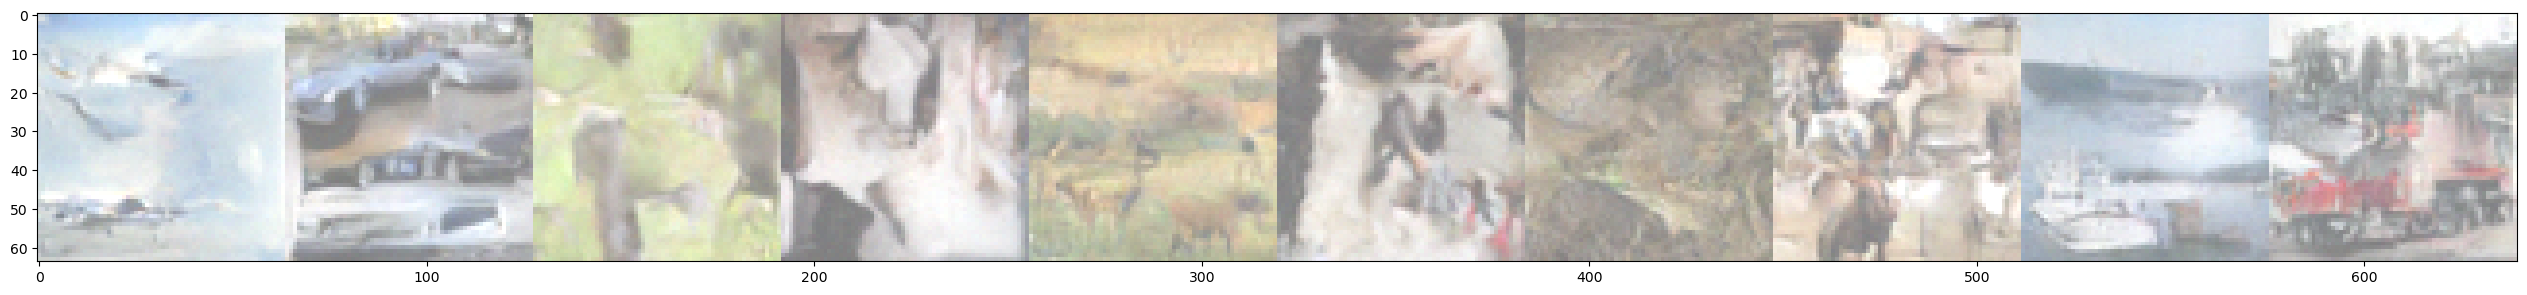

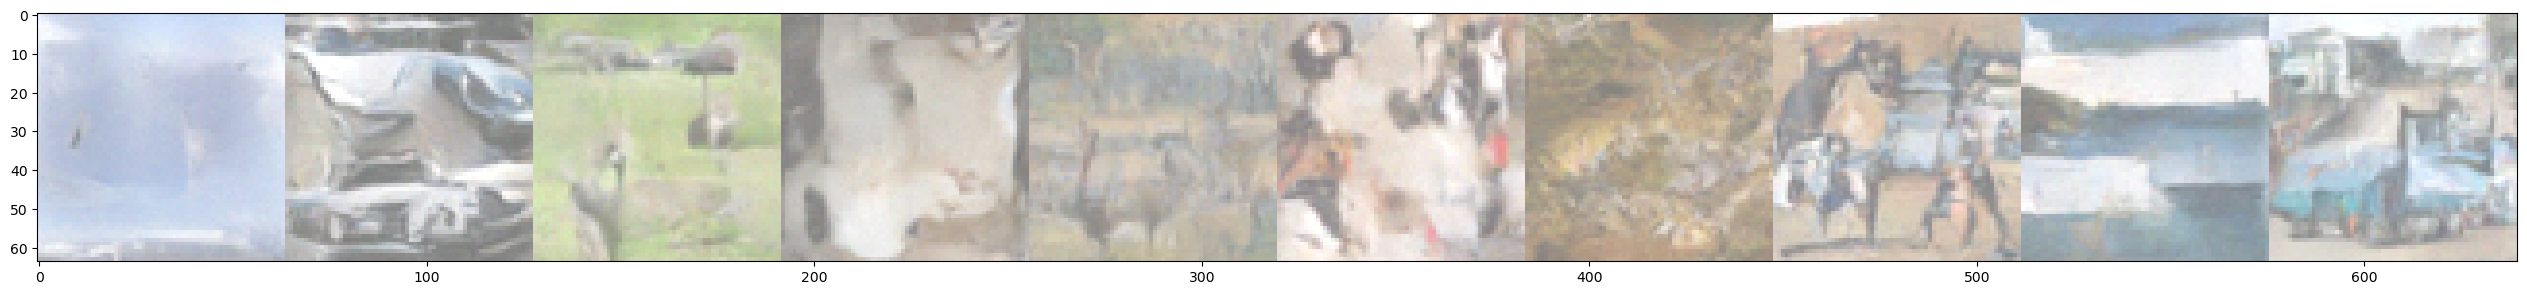

12:57:54 - INFO: Starting epoch 1:


12:59:22 - INFO: Starting epoch 2:


01:00:49 - INFO: Starting epoch 3:


01:02:16 - INFO: Starting epoch 4:


01:03:43 - INFO: Starting epoch 5:


01:05:10 - INFO: Starting epoch 6:


01:06:38 - INFO: Starting epoch 7:


01:08:06 - INFO: Starting epoch 8:


01:09:34 - INFO: Starting epoch 9:


01:11:02 - INFO: Starting epoch 10:


01:12:30 - INFO: Sampling 10 new images....


01:13:50 - INFO: Sampling 10 new images....


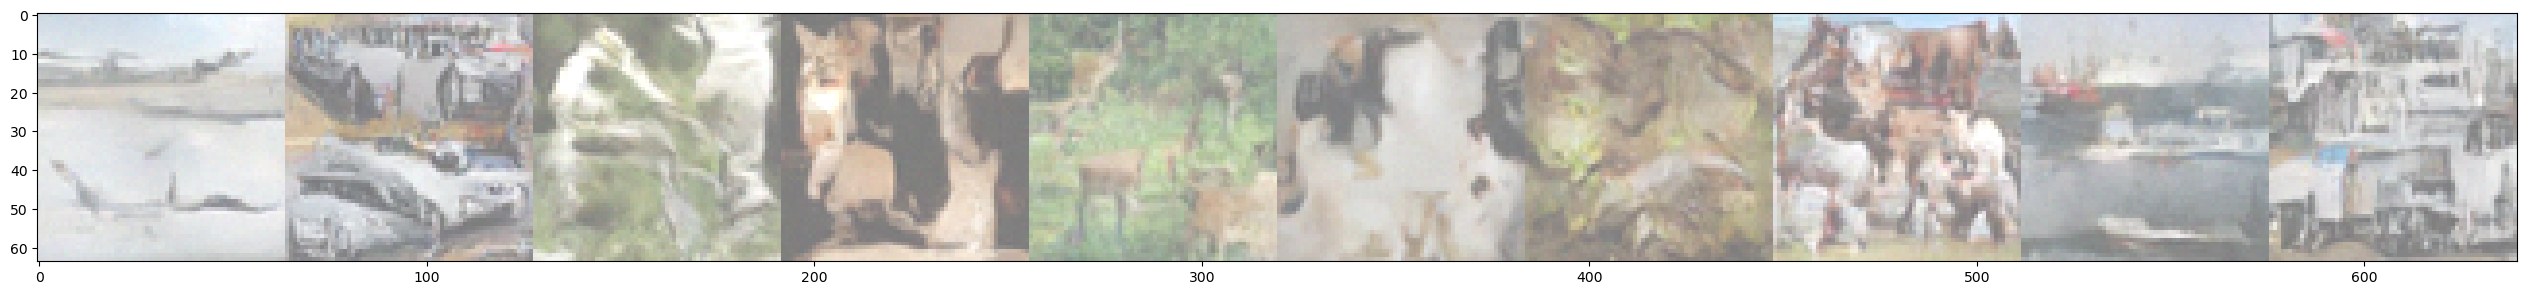

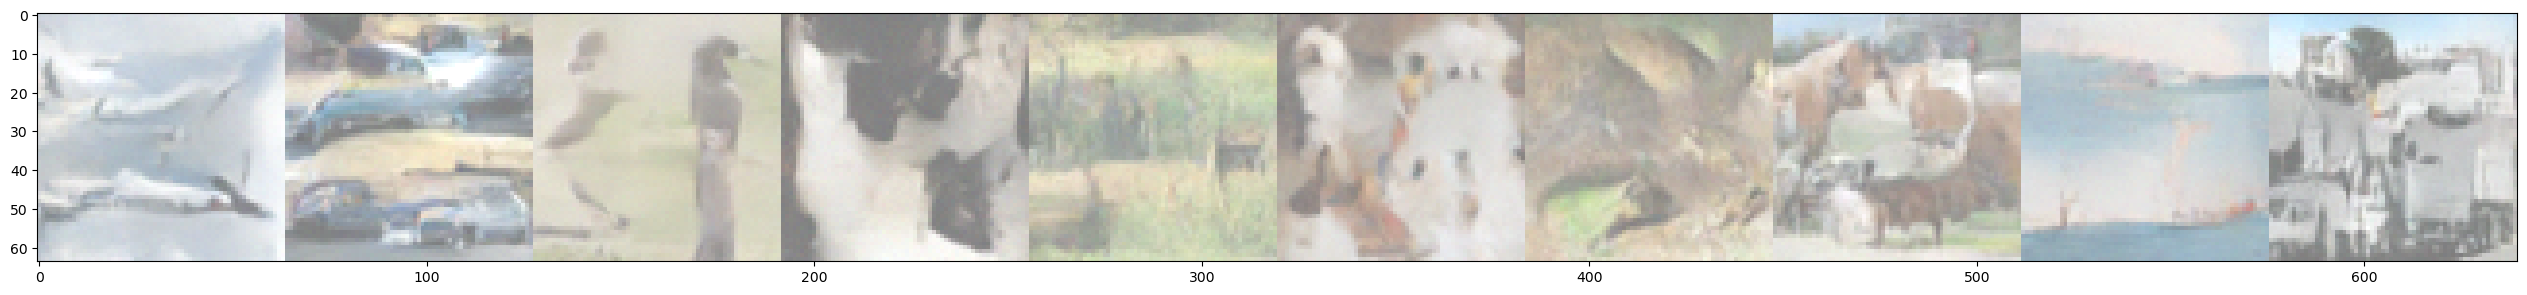

01:15:12 - INFO: Starting epoch 11:


01:16:40 - INFO: Starting epoch 12:


01:18:08 - INFO: Starting epoch 13:


01:19:36 - INFO: Starting epoch 14:


01:21:04 - INFO: Starting epoch 15:


01:22:32 - INFO: Starting epoch 16:


01:24:00 - INFO: Starting epoch 17:


01:25:28 - INFO: Starting epoch 18:


01:26:56 - INFO: Starting epoch 19:


In [ ]:
def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))




diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
with wandb.init(project="train_sd", group="train", config=config):
    diffuser.prepare(config)
    diffuser.load('models/DDPM_conditional')
    diffuser.fit(config)

In [ ]:
import wandb